In [831]:
import numpy as np
# import pandas as pd
from PIL import Image
import os
import time
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Preprocesamiento de imágenes

In [832]:
def image_convert(dir, new_size):
    
    imagenes = []

    for filename in os.listdir(dir):

        file_path = os.path.join(dir, filename)
        # print(f"Procesando imagen {file_path}")
        
        if os.path.isfile(file_path):

            # Sin este if no funciona en mi windows, probar comentarlo en Mac a ver que pasa
            if not filename.lower().endswith('.png'):
                continue

            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size) 
                    img = img.convert('L') # Convertir a escala de grises
                    img_array = np.array(img)/255.0 # Convertir a array y normalizar
                    img_vector = img_array.reshape((new_size[0]**2)) 
                    imagenes.append(img_vector)

            except Exception as e:
                print(f"Error procesando la imagen {file_path}: {e}")

    return np.array(imagenes)

In [833]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = original 

In [834]:
# Convierto todas las imágenes a arreglos de pixeles según el tamaño elegido

# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

cant_healthy = i_healthy.shape[0] # Cantidad de imágenes sanas
print(f"Cantidad de imágenes sanas: {cant_healthy}")
cant_park = i_park.shape[0] # Cantidad de imágenes con Parkinson
print(f"Cantidad de imágenes con Parkinson: {cant_park}")

# Separo en train y test

cant_healthy_train = round(cant_healthy * 0.7) # 70% de las imágenes sanas para entrenamiento
cant_healthy_test = cant_healthy - cant_healthy_train # 30% de las imágenes sanas para test

cant_park_train = round(cant_park * 0.7) # 70% de las imágenes con Parkinson para entrenamiento
cant_park_test = cant_park - cant_park_train # 30% de las imágenes con Parkinson para test

print(f"Cantidad de imágenes sanas para entrenamiento: {cant_healthy_train}")
print(f"Cantidad de imágenes sanas para test: {cant_healthy_test}")

i_healthy_train = i_healthy[:cant_healthy_train]
d_healthy_train = d_healthy[:cant_healthy_train]

i_healthy_test = i_healthy[cant_healthy_train:]
d_healthy_test = d_healthy[cant_healthy_train:]

i_park_train = i_park[:cant_park_train]
d_park_train = d_park[:cant_park_train]

i_park_test = i_park[cant_park_train:]
d_park_test = d_park[cant_park_train:]

# Antes de combinarlos, normalizo
i_healthy_train = i_healthy_train / 255.0
i_park_train = i_park_train / 255.0
i_healthy_test = i_healthy_test / 255.0
i_park_test = i_park_test / 255.0


# Combino sanos y enfermos en train y test
i_train = np.vstack((i_healthy_train, i_park_train)) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy_train, d_park_train)) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy_test, i_park_test)) # Imágenes de test
d_test = np.vstack((d_healthy_test, d_park_test)) # Diagnósticos de test

print(i_train.shape, d_train.shape)
print(i_test.shape, d_test.shape)

# # Mezclo los datos de entrenamiento y test
# np.random.seed(42)  
# indices = np.random.permutation(i_train.shape[0])
# i_train = i_train[indices]
# d_train = d_train[indices]

# indices = np.random.permutation(i_test.shape[0])
# i_test = i_test[indices]
# d_test = d_test[indices]

# NORMALIZO
i_healthy = i_healthy / 255.0
i_park = i_park / 255.0


# Chequeamos que la intersección entre train y test sea nula (Importante)
print(len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0)


Cantidad de imágenes sanas: 816
Cantidad de imágenes con Parkinson: 816
Cantidad de imágenes sanas para entrenamiento: 571
Cantidad de imágenes sanas para test: 245
(1142, 65536) (1142, 1)
(490, 65536) (490, 1)
True


Queremos minimizar la función de pérdida:

$$
\sum_{i=1}^{N} \left( f^*(\mathbf{i}_i) - d_i \right)^2
$$

Es decir, queremos minimizar la diferencia entre los diagnósticos que predice el modelo y los reales. 

Buscamos la mejor solución dentro de las funciones $f : \mathbb{R}^K \to (0, 1)$
 que tengan la forma:

$$
f_{\mathbf{w}, b}(\mathbf{i}) = \frac{\tanh(\mathbf{w} \cdot \mathbf{i} + b) + 1}{2}
$$


donde $w$ es un vector de pesos (weights) de $\mathbb{R}^K$ , $b$ (bias) un escalar, y $tanh$ la tangente hiperbólica.

Convertimos las imágenes a arreglos de pixeles y separamos en train y test

## Derivadas parciales

$$
\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = 
\arg\min_{\mathbf{w}, b} \sum_{i=1}^{N} \left( f_{\mathbf{w}, b}(\mathbf{i}_i) - d_i \right)^2
$$


Derivamos $\mathcal{L}$ con respecto a $b$ (bias) y $w$ (weight):

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial w} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)\cdot i
$$

$$
\frac{\partial \mathcal{L}(\mathbf{w}, b) }{\partial b} = (1-\tanh(b+w^\top \cdot i)^{2})\cdot ((1+\tanh(b+w^\top \cdot i))/2-d)
$$

In [835]:
# def fwb(i, w, b):
#     z = i@w + b 
#     f = (np.tanh(z) + 1) / 2 
#     return f 

In [836]:
# Función a minimizar
def funcion_objetivo(w, b, i, d):
    z = i@w + b 
    f = (np.tanh(z) + 1) / 2 
    return np.sum((f - d) ** 2)

In [837]:
def df_w(w, b, i, d):
    z = i@w + b
    f = (np.tanh(z) + 1) / 2
    
    dz = (1 - np.tanh(z) ** 2) * (f - d)  
    grad_w = i.T @ dz                  
    return grad_w

# def df_w(w, b, i, d):
#     #a partir del calculo de la derivada realizado con matrixcalculus.org
#     f = fwb(i, w, b)
#     tanh_deriv = 1 - np.tanh(i@w + b) ** 2
#     alpha = (tanh_deriv) * (f - d)
#     return i.T@alpha

In [838]:
def df_b(w, b, i, d):
    z = i@w + b
    f = (np.tanh(z) + 1) / 2
    
    dz = (1 - np.tanh(z) ** 2) * (f - d)
    # grad_b = np.sum(dz, axis=0, keepdims=True)  # Da forma (1,1)
    grad_b = np.sum(dz)  # Da un número escalar, que luego se maneja como vector donde todas las coordenadas son iguales
    return grad_b

# def df_b(w, b, i, d):
#     #matrixcalculus.org
#     f = fwb(i, w, b)
#     tanh_deriv = 1 - (np.tanh(i@w + b)) ** 2
#     alpha = (tanh_deriv) * (f - d)
#     return np.sum(alpha) #se va aproximando el b con cada imagen, asi que se suman los resultados para cada una --> numero (luego np lo maneja como vector donde todas las coordenadas seran iguales)


## Gradiente Descendiente

In [839]:
MAX_ITER = 2000

TOLERANCIA = 0.01

def gradient_descent(w, b,imagenes_train, diagnosticos_train, imagenes_test, diagnosticos_test, alpha=0.1):
    
    # # NORMALIZO
    # imagenes_train = imagenes_train / np.max(imagenes_train)
    # imagenes_test = imagenes_test / np.max(imagenes_test)

    
    iter  = 0
    valores_train = []
    valores_test = []

    while iter <= MAX_ITER:
        print("Iteración: ", iter, "- Mínimo alcanzado hasta el momento: ", funcion_objetivo(w, b, imagenes_train, diagnosticos_train))

        valores_train.append(funcion_objetivo(w, b, imagenes_train, diagnosticos_train))

        if imagenes_test is not None and diagnosticos_test is not None: 
          valores_test.append(funcion_objetivo(w, b, imagenes_test, diagnosticos_test))

        gradiente_w = df_w(w, b, imagenes_train, diagnosticos_train) 
        gradiente_b = df_b(w, b, imagenes_train, diagnosticos_train)

        max_norm = 100.0
        norm_w = np.linalg.norm(gradiente_w)
        if norm_w > max_norm:
            gradiente_w = gradiente_w * (max_norm / norm_w)

        print("Norma gradiente_w:", np.linalg.norm(gradiente_w))
        print("gradiente_b:", gradiente_b)
    
        # # Si gradiente_b no es escalar, colapsar con promedio o suma
        # if gradiente_b.ndim > 0 and gradiente_b.size > 1:
        #   gradiente_b = np.mean(gradiente_b)  # O np.sum(gradiente_b)

        w_sig = w - alpha * gradiente_w
        b_sig = b - alpha * gradiente_b

        criterio = np.abs(funcion_objetivo(w_sig, b_sig, imagenes_train, diagnosticos_train) - funcion_objetivo(w, b, imagenes_train, diagnosticos_train))

        if criterio < TOLERANCIA: # Converge
          print("criterio de convergencia alcanzado")
          break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores_train, valores_test

In [840]:
w = np.random.uniform(-1,1,(i_train[0].shape[0],1))  * 0.001
b = np.random.uniform(-1,1) * 0.001

In [841]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.001
b = np.random.uniform(-1, 1) * 0.001
alpha = 0.000001
w_opt, b_opt, f_obj_values, f_test = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha)


Iteración:  0 - Mínimo alcanzado hasta el momento:  285.5007609248898
Norma gradiente_w: 2.3724540230372813
gradiente_b: 0.08873949848646134
criterio de convergencia alcanzado


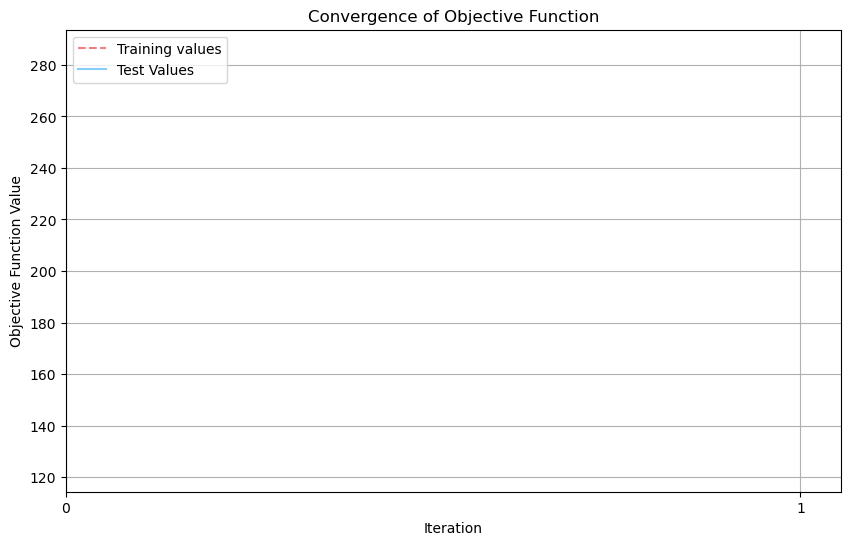

In [842]:
plt.figure(figsize=(10, 6))

#train
plt.plot(np.arange(1, len(f_obj_values) + 1), f_obj_values, linestyle='--', color='lightcoral', label='Training values')
#test
plt.plot(np.arange(1, len(f_test) + 1), f_test, linestyle='-', color='lightskyblue', label='Test Values')

tick_interval = max(1, len(f_obj_values) // 20)
plt.xticks(np.arange(0, len(f_obj_values) + 1, step=tick_interval))

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergence of Objective Function')
plt.grid(True)
plt.legend()  
plt.show()

In [843]:
# w, b, valores_train, valores_test = gradiente_descendente(
#     b=np.zeros((1, 1)), 
#     w=np.zeros((i_train.shape[1], 1)), 
#     imagenes_train=i_train, 
#     diagnosticos_train=d_train, 
#     imagenes_test=i_test, 
#     diagnosticos_test=d_test, 
#     alpha=0.01
# )

# plt.plot(valores_train, label="Entrenamiento")
# plt.plot(valores_test, label="Test")
# plt.xlabel("Iteración")
# plt.ylabel("Pérdida (loss)")
# plt.title("Gradient Descent - Alpha = 0.01")
# plt.legend()
# plt.grid(True)
# plt.show()

In [844]:
# w, b, valores_train, valores_test = gradiente_descendente(
#     b=np.zeros((1, 1)), 
#     w=np.zeros((i_train.shape[1], 1)), 
#     imagenes_train=i_train, 
#     diagnosticos_train=d_train, 
#     imagenes_test=i_test, 
#     diagnosticos_test=d_test, 
#     alpha=0.0
# )

# plt.plot(valores_train, label="Entrenamiento")
# plt.plot(valores_test, label="Test")
# plt.xlabel("Iteración")
# plt.ylabel("Pérdida (loss)")
# plt.title("Gradient Descent - Alpha = 0.009")
# plt.legend()
# plt.grid(True)
# plt.show()